## Performance Curve

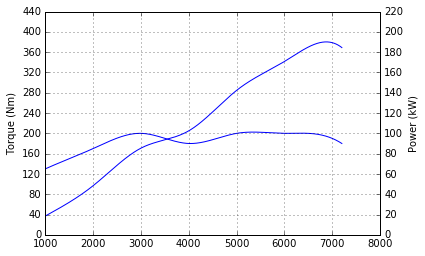

In [25]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

rpm_points = np.array([1000,1500,2000,3000,4000,5000,6000,6500,7000,7200]) # rpm
torque_points = np.array([130,150,170,200,180,200,200,200,190,180]) # Nm
power_points = torque_points*(rpm_points*2*np.pi/60) # W
power_ps_points = torque_points*(rpm_points*2*np.pi/60)/1000*1.35962 # PS
res = 1000
N = 12

rpm2t = interpolate.splrep(rpm_points,torque_points)
rpm2pow = interpolate.splrep(rpm_points,power_points)
rpm2ps = interpolate.splrep(rpm_points,power_ps_points)
rpm = np.linspace(1000,rpm_points[-1],res) # rpm
torque = interpolate.splev(rpm,rpm2t) #

#power = torque*(rpm*2*np.pi/60)/1000 # kW
#power_ps = power*1.35962
power_ps = interpolate.splev(rpm,rpm2ps)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rpm,torque)
ax.set_ylabel("Torque (Nm)")
ax.set_xlim(0,8000)
ax.set_ylim(0,320)
ax.set_yticks([i*40 for i in range(N)])
ax.grid()

ax2 = ax.twinx()
ax2.plot(rpm,power_ps)
ax2.set_ylabel("Power (kW)")
ax2.set_ylim(0,160)
ax2.set_yticks([i*20 for i in range(N)])

plt.show()

In [76]:
m = 1480 # kg

n_gears = 6
rev_limit = 7000 # rpm
rev_drop_rate = 3000 # rpm
shift_time = 0.5 # seconds
wheel_radius = 0.3 # m
gears = np.array([0,3.538,2.060,1.404,1.000,0.713,0.582])*4.100
cd = 0.3
S = 0.55 # m^2
rho = 1.225 # kg/m^3 @ 15C, 1013hPa

dt =  0.02 # seconds
tmax = 10.0
N = int(tmax/dt)

t0,g0,th0,rpm0,a0,v0,p0 = 0,1,0,1000,0,0.1,0
history = [[t0,g0,th0,rpm0,a0,v0,p0]] # t,gear,throttle,rpm,acceleration,velocity,position

t_shift = None
for i in range(N):
    t,g,th,rpm,a,v,p = tuple(history[-1])
    
    #rpm = min(rpm,rev_limit) # rev limiter
    
    t += dt
    if t_shift==None:
        th2 = 1.0 # flat out
    else:
        th2 = 0.0
    
    # acceleration
    torque_engine = th*interpolate.splev([rpm],rpm2t)[0] # W
    torque_wheel = torque_engine * gears[g]
    thrust = torque_wheel/wheel_radius #N
    drag = cd*S*(0.5*rho*v*v)
    a2 = (thrust-drag)/m
    
    omega_dot_wheel = a/wheel_radius
    omega_dot_engine = omega_dot_wheel*gears[g]
    
    # integrate
    p2 = p + v*dt
    v2 = v + a*dt
    rpm2 = rpm + (omega_dot_engine*dt)*60/(2*np.pi)
    
    
    # gear shift
    g2 = g
    if rpm2>rev_limit and t_shift==None:
        if g2<len(gears)-1:
            g2 += 1
            t_shift = 0.0
        else: # top gear
            rpm2 = rev_limit
    if t_shift!=None:
        t_shift+=dt
        rpm2-=rev_drop_rate*dt
        if t_shift>shift_time:
            t_shift=None
            

    
    history.append([t,g2,th2,rpm2,a2,v2,p2])



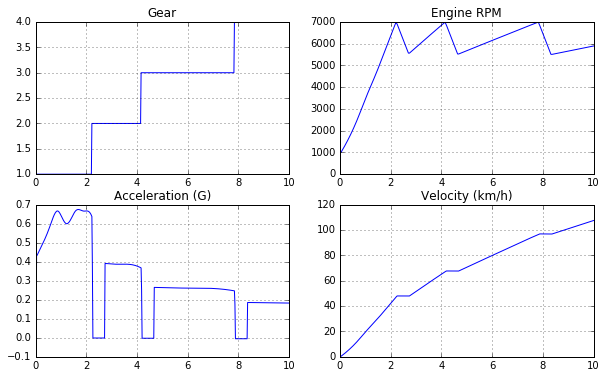

In [77]:
history = np.array(history)

fig, axes = plt.subplots(2,2,figsize=(10,6))
axes[0,0].plot(history[:,0],history[:,1])
axes[0,0].grid()
axes[0,0].set_title("Gear")
axes[0,1].plot(history[:,0],history[:,3])
axes[0,1].grid()
axes[0,1].set_title("Engine RPM")
axes[1,0].plot(history[:,0],history[:,4]/9.8)
axes[1,0].grid()
axes[1,0].set_title("Acceleration (G)")
axes[1,1].plot(history[:,0],history[:,5]*3.6)
axes[1,1].grid()
axes[1,1].set_title("Velocity (km/h)")